## Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.

Solution: [homework.ipynb](homework.ipynb)

In this homework, we will use the Bank Marketing dataset. Download it from [here](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

You can do it with `wget`:

```bash
wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
unzip bank+marketing.zip 
unzip bank.zip
```

We need `bank-full.csv`.

In this dataset the target variable is `y` variable - has the client subscribed a term deposit or not. 



### Dataset preparation

For the rest of the homework, you'll need to use only these columns:

* `'age'`,
* `'job'`,
* `'marital'`,
* `'education'`,
* `'balance'`,
* `'housing'`,
* `'contact'`,
* `'day'`,
* `'month'`,
* `'duration'`,
* `'campaign'`,
* `'pdays'`,
* `'previous'`,
* `'poutcome'`,
* `'y'`



Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`



In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split

columns_to_select = [
    "age",
    "job",
    "marital",
    "education",
    "balance",
    "housing",
    "contact",
    "day",
    "month",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
]

df_full = pd.read_csv("bank-full.csv", sep=";")

y = (df_full.y == "yes").astype(int).values
df = df_full.drop(columns=["y"])[columns_to_select].copy()

# split factors
test_size = 0.2
train_size = 0.2
train_size_of_full_train = train_size / (1 - test_size)

# splitting
df_full_train, df_test, y_full_train, y_test = train_test_split(
    df, y, test_size=test_size, random_state=1
)
df_train, df_val, y_train, y_val = train_test_split(
    df_full_train, y_full_train, test_size=train_size_of_full_train, random_state=1
)

In [58]:
y

array([0, 0, 0, ..., 1, 0, 0], shape=(45211,))

In [59]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
dtype: object

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `balance`
- `day`
- `duration`
- `previous`


In [60]:
from sklearn.metrics import roc_auc_score

numerical = ["age", "balance", "day", "duration", "campaign", "previous"]

feature_scores = {}
for variable in numerical:
    roc_score = roc_auc_score(y_train, df_train[variable].values)
    roc_score = 1 - roc_score if roc_score < 0.5 else roc_score
    feature_scores[variable] = roc_score

dict(sorted(feature_scores.items(), key=lambda item: item[1], reverse=True))

{'duration': 0.8147002759670778,
 'previous': 0.5985653242764153,
 'balance': 0.5888313805382317,
 'campaign': 0.5714543015682159,
 'day': 0.525957882383908,
 'age': 0.5121857175273441}

In [61]:
# 1 - auc(true, score) = auc(true, -score)
print(1 - roc_auc_score(y_train, df_train["campaign"].values))
print(roc_auc_score(y_train, -df_train["campaign"].values))

0.5714543015682159
0.5714543015682159


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.69
- 0.79
- 0.89
- 0.99



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer


def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def predict(df, dv, model):
    dicts = df.to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [63]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

round(roc_auc_score(y_val, y_pred), 3)

0.9


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.265
* 0.465
* 0.665
* 0.865



In [ ]:
import numpy as np

# precision = TP/(TP + FP)
# recall = TP/(TP + FN)
precisions = []
recalls = []


thresholds = np.arange(0.0, 1.0, 0.01)
for t in thresholds:
    predicts = y_pred >= t

    tp = (predicts & (y_val == 1)).sum()
    tn = (~predicts & (y_val == 0)).sum()

    fp = (predicts & (y_val == 0)).sum()
    fn = (~predicts & (y_val == 1)).sum()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    precisions.append(precision)
    recalls.append(recall)

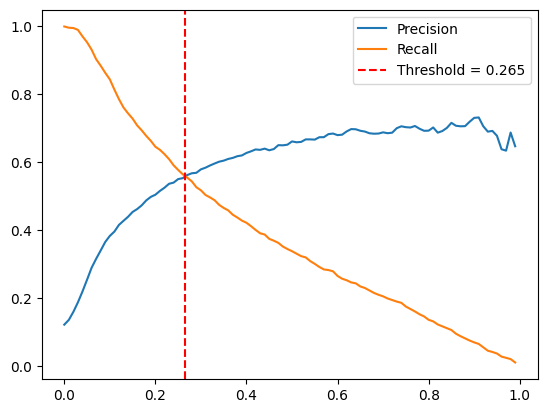

In [ ]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.axvline(x=0.265, color="red", linestyle="--", label="Threshold = 0.265")
plt.legend()
plt.show()

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62



In [ ]:
precisions = np.array(precisions)
recalls = np.array(recalls)

f1 = 2 * (precisions * recalls) / (precisions + recalls)

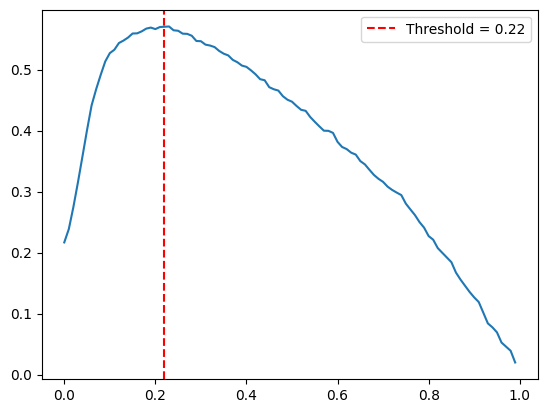

In [ ]:
plt.plot(thresholds, f1)
plt.axvline(x=0.22, color="red", linestyle="--", label="Threshold = 0.22")
plt.legend()
plt.show()


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26



In [90]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

aucs = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dv, model = train(df_train, y_train)
    p_predict = predict(df_val, dv, model)

    aucs.append(roc_auc_score(y_val, p_predict))

print(f"mean: {np.mean(aucs):.2f}, std: {np.std(aucs):.2f}")
aucs

mean: 0.91, std: 0.01


[0.8993556310932126,
 0.8993206548548723,
 0.9112583997605899,
 0.9081048228522398,
 0.9120491718502978]

### Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [94]:
Cs = [0.000001, 0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]

for C in Cs:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    aucs = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]

        dv, model = train(df_train, y_train, C=C)
        p_predict = predict(df_val, dv, model)

        aucs.append(roc_auc_score(y_val, p_predict))

    print(f"C: {C}, mean: {np.mean(aucs):.3f}, std: {np.std(aucs):.3f}")

C: 1e-06, mean: 0.701, std: 0.009
C: 0.001, mean: 0.861, std: 0.007
C: 0.01, mean: 0.902, std: 0.005
C: 0.1, mean: 0.906, std: 0.005
C: 0.5, mean: 0.906, std: 0.005
C: 1, mean: 0.906, std: 0.006
C: 1.5, mean: 0.906, std: 0.006
C: 2, mean: 0.906, std: 0.006
